# How is resolution computed

## Index

- [Normal distribution](#Normal-distribution)   

- [Resolution](#Resolution)    

- [Relative scaling](#Relative-scaling)    

- [Error bars](#Error-bars)    

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ctaplot.ana import resolution, relative_scaling

## Normal distribution
For a nomal distribution, $\sigma$ corresponds to the 68 percentile of the distribution   
See the [68–95–99.7 rule](https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule)

68th percentile = 3.0016
95th percentile = 5.9941
99th percentile = 8.9812


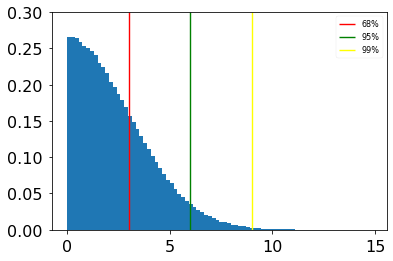

In [2]:
loc = 10
scale = 3

X = np.random.normal(size=1000000, scale=scale, loc=loc)
plt.hist(np.abs(X - loc), bins=80, density=True)

sig_68 = np.percentile(np.abs(X - loc), 68.27)
sig_95 = np.percentile(np.abs(X - loc), 95.45)
sig_99 = np.percentile(np.abs(X - loc), 99.73)

plt.vlines(sig_68, 0, 0.3, label='68%', color='red')
plt.vlines(sig_95, 0, 0.3, label='95%', color='green')
plt.vlines(sig_99, 0, 0.3, label='99%', color='yellow')
plt.ylim(0,0.3)
plt.legend()


print("68th percentile = {:.4f}".format(sig_68))
print("95th percentile = {:.4f}".format(sig_95))
print("99th percentile = {:.4f}".format(sig_99))

assert np.isclose(sig_68, scale, rtol=1e-2)
assert np.isclose(sig_95, 2 * scale, rtol=1e-2)
assert np.isclose(sig_99, 3 * scale, rtol=1e-2)

## Resolution
The resolution is defined as the 68th percentile of the relative error `err = (reco - simu)/scaling`.   
(see the [relative scaling](#Relative-scaling) section for more info on it).    
Hence, if the relative error follows a normal distribution, the resolution is equal to the sigma of the distribution

Text(0.5, 1.0, 'err')

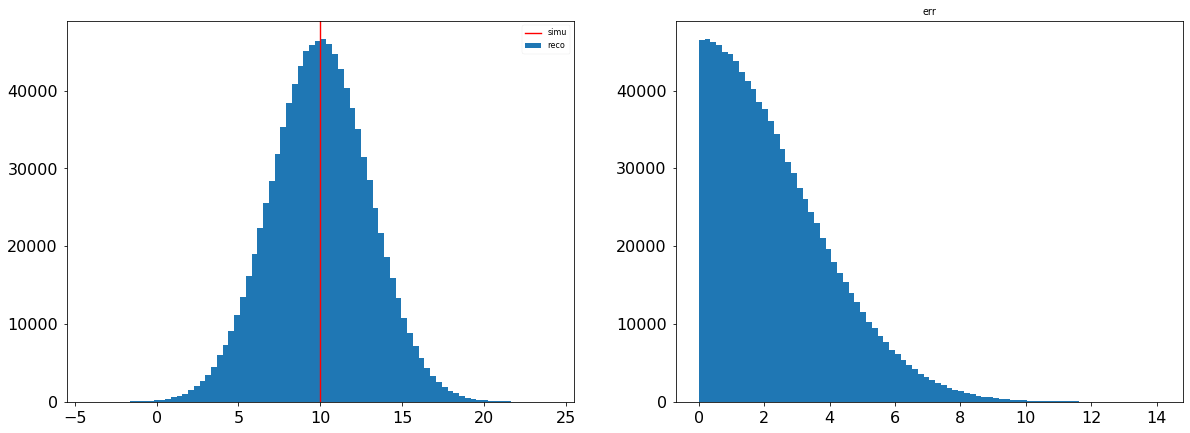

In [3]:
simu = loc * np.ones(X.shape[0])
reco = np.random.normal(loc=loc, scale=scale, size=X.shape[0])

err = np.abs(simu - reco)

fig, axes = plt.subplots(1, 2, figsize=(20,7))
axes[0].hist(reco, bins=80, label='reco')
axes[0].axvline(loc, 0, 1, color='red', label='simu')
axes[0].legend()
axes[1].hist(err, bins=80)
axes[1].set_title('err')

Let's define `reco` in order to have a relative error equals to `err`.   
Its resolution is equals to the sigma of the distribution

In [4]:
res = resolution(simu, reco, relative_scaling_method=None)
print(res)
assert np.isclose(res[0], scale, rtol=1e-2)

[3.00210261 2.99740973 3.0068767 ]


----
## Relative scaling

The resolution can be measured on the absolute error or on the relative one.  

$$ err = (reco - simu)/scaling $$ 


There is no absolute definition of the relative scaling and several are proposed in `ctaplot`.    
The choice can be passed through the `relative_scaling_method`:     

Methods:     
- `s0` : no scaling (scaling = 1)    
- `s1` : $ scaling = |simu| $     
- `s2` : $ scaling = |reco| $     
- `s3` : $ scaling = (|simu| + |reco|)/2 $     
- `s4` : $ scaling = max(|reco|, |simu|) $    

The default one for the resolution is `s1`.  

Note that methods involving `reco` are more subject to deviation from the expected result:

In [5]:
for method in ['s1', 's2', 's3', 's4']:
    res = resolution(simu, reco, relative_scaling_method=method)
    print("Method {} gives a resolution = {:.3f} to be compared with the expected value = {}".format(method, res[0], scale/loc))

Method s1 gives a resolution = 0.300 to be compared with the expected value = 0.3
Method s2 gives a resolution = 0.288 to be compared with the expected value = 0.3
Method s3 gives a resolution = 0.297 to be compared with the expected value = 0.3
Method s4 gives a resolution = 0.258 to be compared with the expected value = 0.3


NB:    
- the angular resolution uses no scaling     
- the energy resolution uses scaling `s1`     
- the impact resolution uses no scaling by default     

---
## Error bars

Errors bars in resolution plots are given by the [confidence interval](https://en.wikipedia.org/wiki/Confidence_interval ) (by default at 95%, equivalent to 2 sigmas for a normal distribution).    
This means that we can be confident at 95% that the resolution values are within the range given by the error bars.

The implementation for percentile confidence interval follows:
- http://people.stat.sfu.ca/~cschwarz/Stat-650/Notes/PDF/ChapterPercentiles.pdf    

Example with a normal distribution:

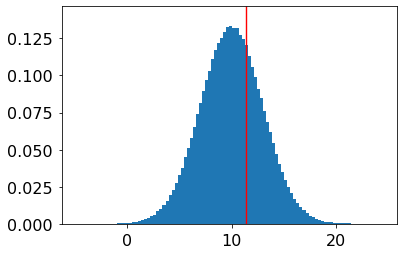

The true 68th percentile of this distribution is: 11.4245


In [6]:
nbins, bins, patches = plt.hist(X, bins=100, density=True)
ymax = 1.1 * nbins.max()
plt.ylim(0, ymax)
plt.vlines(np.percentile(X, 68.27), 0, ymax, color='red')
plt.show()
print("The true 68th percentile of this distribution is: {:.4f}".format(np.percentile(X, 68.27)))

We can consider this as our underlying (infinite) distribution.     
If we take a random sample in this ditribution, the measurement of a percentile will come with a measurement error.
We can assess this error by taking multiple random samples and taking the distribution of measured percentile values.

Standard deviation = 0.12287


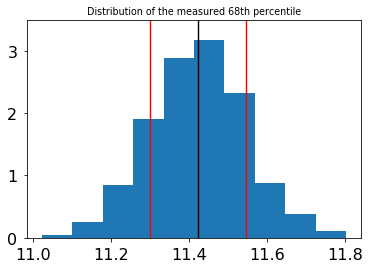

In [7]:
n = 1000
p = 0.6827
all_68 = []
for i in range(int(len(X)/n)):
    all_68.append(np.percentile(X[i*n:(i+1)*n], p*100))
    
all_68 = np.array(all_68)
nbins, bins, patches = plt.hist(all_68, density=True);
ymax = 1.1 * nbins.max()
plt.vlines(all_68.mean(), 0, ymax)
plt.vlines(all_68.mean() + all_68.std(), 0, ymax, color='red')
plt.vlines(all_68.mean() - all_68.std(), 0, ymax, color='red')
plt.ylim(0, ymax)
plt.title("Distribution of the measured 68th percentile")

print("Standard deviation = {:.5f}".format(all_68.std()))

To evaluate directly the confidence interval from a sub-sample of the distribution, one can use the following formulae:    
    $$ R_{low} = n*p − z * \sqrt{n * p * (1 − p)} $$
    $$ R_{up} = n*p + z * \sqrt{n * p * (1 − p)} $$
    
with $p$ the percentile and $z$ the confidence level desired.

And the confidence interval given by: ($X[R_{low}], X[R_{up}])$

The confidence level is given by the cumulative distribution function (`scipy.stats.norm.ppf`).    
Some useful values:   

- z = 0.47 for a confidence level of 68%    
- z = 1.645 for a confidence level of 95%    
- z = 2.33 for a confidence level of 99%    

In [8]:
# confidence level:
z = 2.33

# sub-sample:
x = X[:n]

rl = int(n * p - z * np.sqrt(n * p * (1-p)))
ru = int(n * p + z * np.sqrt(n * p * (1-p)))
print("Measured percentile: {:.4f}".format(np.percentile(x, p*100)))
print("Confidence interval: ({:.4f}, {:.4f})".format(np.sort(x)[rl], np.sort(x)[ru]))
print("To be compared with: ({:.4f}, {:.4f})".format(all_68.mean()-all_68.std()*3, all_68.mean()+all_68.std()*3))
print("which is the corresponding confidence interval given by the normal distribution of the measured percentiles")

Measured percentile: 11.4301
Confidence interval: (11.1279, 11.7104)
To be compared with: (11.0539, 11.7911)
which is the corresponding confidence interval given by the normal distribution of the measured percentiles


In ctaplot, this is computed by the function `percentile_confidence interval`:

68th percentile: 11.430
Interval with a confidence level of 99.0%: (11.128, 11.710)


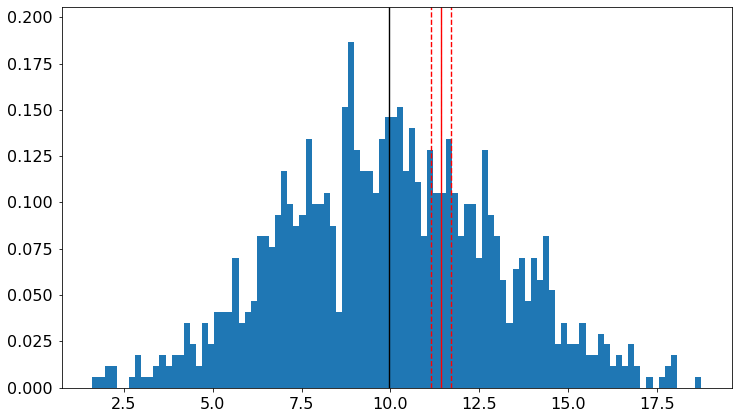

In [9]:
from ctaplot.ana import percentile_confidence_interval

p = 68.27
confidence_level = 0.99
pci = percentile_confidence_interval(x, percentile=p, confidence_level=0.99)
print("68th percentile: {:.3f}".format(np.percentile(x, p)))
print("Interval with a confidence level of {}%: ({:.3f}, {:.3f})".format(confidence_level*100, pci[0], pci[1]))


plt.figure(figsize=(12,7))
nbins, bins, patches = plt.hist(x, bins=100, density=True);
ymax = 1.1 * nbins.max()

plt.vlines(np.percentile(x, 50), 0, ymax, color='black')
plt.vlines(np.percentile(x, p), 0, ymax, color='red')
plt.vlines(pci[0], 0, ymax, linestyles='--', color='red')
plt.vlines(pci[1], 0, ymax, linestyles='--', color='red',)
plt.ylim(0, ymax);

--- 
Note: The same method could be applied around the median.    
In this case, the confidence interval is also given by $-\sigma/\sqrt{n}$ for a normal distribution.

In [10]:
pci = percentile_confidence_interval(X, percentile=50, confidence_level=0.99)
print("Median: {:.5f}".format(np.median(X)))
print("Confidence interval at 99%: {}".format(pci))
print("To be compared with: ({}, {})".format(np.median(X)-3*scale/np.sqrt(len(X)), np.median(X)+3*scale/np.sqrt(len(X))))

Median: 10.00197
Confidence interval at 99%: (9.992948666358563, 10.01069362511663)
To be compared with: (9.992972062483608, 10.010972062483608)
